In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.segmentation.fcn import FCN
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import *
from torch.nn.functional import relu

class Model(Module):
    def __init__(self, in_channels, n_classes):
        super(Model, self).__init__()
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = MaxPool2d((2,2))
        self.conv2 = Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.maxpool2 = MaxPool2d((2,2))
        self.tconv1 = ConvTranspose2d(in_channels=32, out_channels=16, stride=2, kernel_size=5, padding=2, output_padding=1)
        self.tconv2 = ConvTranspose2d(in_channels=16, out_channels=n_classes, stride=2, kernel_size=3, padding=1, output_padding=1)

    def forward(self, x):
        out = relu(self.conv1(x))
        out = self.maxpool1(out)
        out = relu(self.conv2(out))
        out = self.maxpool2(out)
        out = relu(self.tconv1(out))
        out = self.tconv2(out)
        
        return out

# Training
BATCH_SIZE = 16
EPOCHS = 10
N_CLASSES = 5
N_CHANNELS = 6


train_X = torch.tensor(np.load('data/processed/train_input.npy').transpose(0,3,1,2)).float()
train_Y = torch.tensor(np.load('data/processed/train_labels.npy')).long()
test_X = torch.tensor(np.load('data/processed/test_input.npy').transpose(0,3,1,2)).float()
test_Y = torch.tensor(np.load('data/processed/test_labels.npy')).long()

# model = torchvision.models.segmentation.fcn_resnet50(num_classes=N_CLASSES)
model = Model(in_channels=N_CHANNELS, n_classes=N_CLASSES)
criterion = CrossEntropyLoss(ignore_index=0) # Ignore all pixels that are outside of shapefile(mark as 0 in the target image)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2]:
train_set = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

for ep in range(EPOCHS):
    ep_loss = 0.
    for x, y in train_loader:
        optimizer.zero_grad()
        predict = model(x)
        loss = criterion(predict, y)
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
    print(f'Ep {ep+1} Loss : {ep_loss}')

Ep 1 Loss : 77.8556312918663
Ep 2 Loss : 67.99011605978012
Ep 3 Loss : 60.90984129905701
Ep 4 Loss : 58.273064970970154
Ep 5 Loss : 57.40125650167465
Ep 6 Loss : 56.41487181186676
Ep 7 Loss : 55.52665156126022
Ep 8 Loss : 55.65632051229477
Ep 9 Loss : 54.88963806629181
Ep 10 Loss : 54.68954735994339


In [3]:
model.eval()
test_set = TensorDataset(test_X, test_Y)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

test_loss = 0.
for x, y in test_loader:
    predict = model(x)
    loss = criterion(predict, y)
    test_loss += loss.item()

print(f'Test loss : {test_loss}')

Test loss : 23.963720321655273


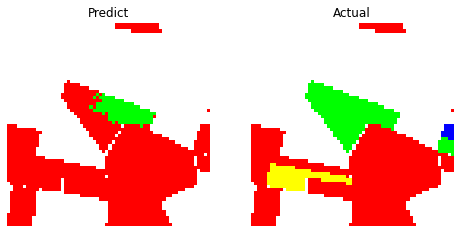

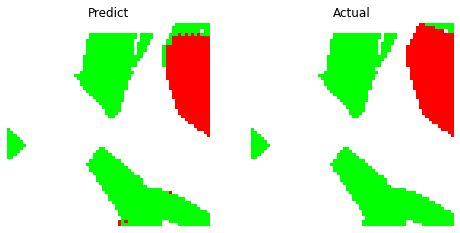

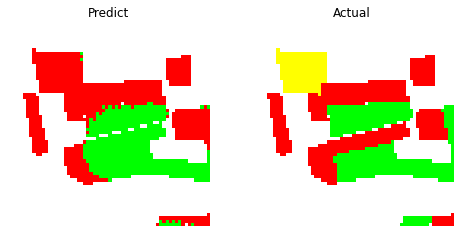

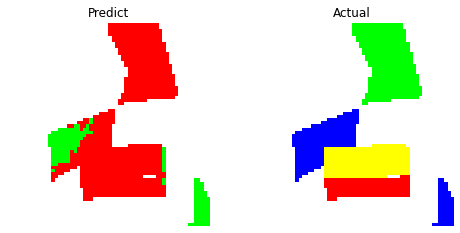

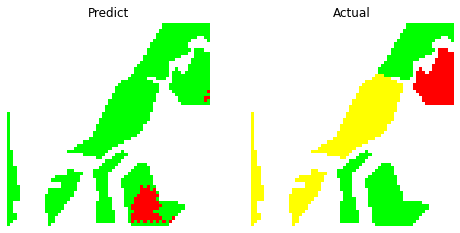

In [4]:
test_samples, test_labels = next(iter(test_loader))
test_predicts = model(test_samples).argmax(dim=1) * (test_labels != 0).int()

color_map = {0: np.array([255, 255, 255]), # Unknown, white
             1: np.array([255, 0, 0]),     # Cassava, red
             2: np.array([0, 255, 0]),     # Maize, green
             3: np.array([0, 0, 255]),     # Rice, blue 
             4: np.array([255, 255, 0])}   # Sugarcane, yellow

def assign_class_color(class_map):
    output = np.zeros((class_map.shape[0], class_map.shape[1], 3), dtype=int)
    for i in range(class_map.shape[0]):
        for j in range(class_map.shape[1]):
            output[i][j] = color_map[class_map[i][j]]

    return output

for i in range(5):
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(assign_class_color(test_predicts[i].detach().numpy()))
    plt.axis('off')
    plt.title('Predict')
    plt.subplot(122)
    plt.imshow(assign_class_color(test_labels[i].detach().numpy()))
    plt.axis('off')
    plt.title('Actual')